In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
class SoftOps:
    """
    A collection of not-very-continuous functions, but with continuous gradients
    """
    @staticmethod
    def with_grad(f, g, name='custom_gradient'):
        """
        Creates a hacked up tensor that evaluates as `f`, but has the gradient of `g`.
        
        https://stackoverflow.com/a/36480182/995480
        """
        with tf.name_scope(name):
            return g + tf.stop_gradient(f - g)

    @staticmethod
    def floor(x, name='soft_floor'):
        return SoftOps.with_grad(tf.floor(x), x, name = name)

    @staticmethod
    def ceil(x, name='soft_ceil'):
        return SoftOps.with_grad(tf.floor(x), x, name = name)

    @staticmethod
    def round(x, name='soft_round'):
        return SoftOps.with_grad(tf.round(x), x, name = name)

    @staticmethod
    def threshold(x, ym=0, yp=1, softness=1, soft_value=True, soft_grad=True, threshold_func=tf.sigmoid, name='soft_threashold'):
        with tf.name_scope(name):
            if softness != 1:
                x /= softness
            soft_q = tf.identity(threshold_func(x), 'soft_q')
            hard_q = tf.where(x > 0, tf.ones(tf.shape(x)),  tf.zeros(tf.shape(x)), name='hard_q')
            soft_y = tf.add((1-soft_q) * ym, soft_q * yp, name='soft_value')
            hard_y = tf.add((1-hard_q) * ym, hard_q * yp, name='hard_value')

            return SoftOps.with_grad(
                soft_y if soft_value else hard_y, 
                soft_y if soft_grad else hard_y)

    @staticmethod
    def gt(a, b, ym=0, yp=1, *args, **kwargs):
        kwargs.setdefault('name', 'soft_gt')
        return SoftOps.threshold(a-b, ym=ym, yp=yp, *args, **kwargs)
    @staticmethod
    def lt(a, b, ym=0, yp=1, *args, **kwargs):
        kwargs.setdefault('name', 'soft_lt')
        return SoftOps.threshold(b-a, ym=ym, yp=yp, *args, **kwargs)
    @staticmethod
    def lte(a, b, ym=0, yp=1, *args, **kwargs):
        kwargs.setdefault('name', 'soft_lte')
        return SoftOps.gt(a, b, ym=yp, yp=ym, *args, **kwargs)
    @staticmethod
    def gte(a, b, ym=0, yp=1, *args, **kwargs):
        kwargs.setdefault('name', 'soft_gte')
        return SoftOps.lt(a, b, ym=yp, yp=ym, *args, **kwargs)

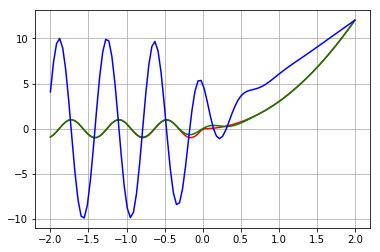

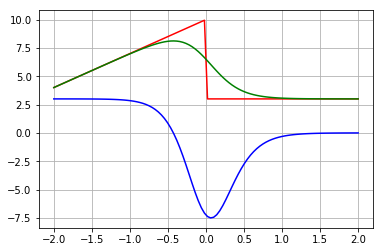

In [3]:
with tf.Graph().as_default():
    x = tf.placeholder(tf.float32, shape=(None), name="x")
    
    for y1, y2 in [(tf.sin(10*x), 3*x**2), (10+3*x, 3)]:
        y = SoftOps.threshold(x, y1, y2, softness=.2, soft_value=False, soft_grad=True)
        y_soft = SoftOps.threshold(x, y1, y2, softness=.2, soft_value=True, soft_grad=True)
        gradient = tf.gradients(y, [x])

        with tf.Session() as session:
            data_x = np.linspace(-2, 2, 100)
            data_y, data_y_soft, data_grad = session.run([y, y_soft, gradient], feed_dict={x: data_x})
        
            #print(data_y)
            #print(data_grad)
            plt.grid(True)
            plt.plot(
                data_x, data_y, 'r-', 
                data_x, data_y_soft, 'g-', 
                data_x, data_grad[0], 'b-'
            )
            plt.show()